### Project Title: Grouping StackOverflow Comments to improve Software Develpment Practices

#### We have merged post and comments dataset pased on post id and saved it as Comments_Ds.csv

In [34]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Read the comments.csv files into DataFrames
df_comments = pd.read_csv('Comments_Ds.csv')



#### Below blocks shows the total number of comments and posts used in this grouping

In [35]:
df_comments.shape

(345529, 12)

In [72]:
df_comments['post_id'].nunique()

41794

In [36]:
df_comments.columns

Index(['id', 'post_type_id', 'parent_id', 'score', 'title', 'body', 'tags',
       'comment_count', 'comment_id', 'post_id', 'text', 'user_id'],
      dtype='object')

In [37]:
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DHANASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DHANASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DHANASHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Text Preprocessing

In [38]:
# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
        
    # Remove punctuation except for @ and #
    #text = re.sub(r'[^\w\s#@]', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))    
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize text into individual words
    words = nltk.word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a single string separated by space
    text = ' '.join(words)
    
    return text


# Preprocess comments
df_comments['preprocessed_text'] = df_comments['text'].apply(preprocess)

#### Calculating length for the Comment Text to use it as a feature

In [39]:
 # Calculate the length of each comment
df_comments['length'] = df_comments['preprocessed_text'].apply(len)


In [40]:
df_comments.head(1)

,id,post_type_id,parent_id,score,title,body,tags,comment_count,comment_id,post_id,text,user_id,preprocessed_text,length
0,11,1,-999,31,How can I tweak my Linux desktop to be more re...,<p>I have the experience that Linux works fine...,<linux><kernel><performance><io><swap>,8,849,11,This is a known issue with the linux kernel......,29,known issue linux kernel believe read recently...,84


#### Clustering the comments for each post and we have used '3' clusters

In [41]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the number of clusters
num_clusters = 3

# Concatenate the 'preprocessed_text', 'length', and 'user_id' columns into a single text column
df_comments['feature_text'] = df_comments.apply(lambda x: x['preprocessed_text'] + '|' + str(x['length']) + '|' + str(x['user_id']), axis=1)

# Create a TfidfVectorizer object to convert comments to a numeric matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')

# Create a dictionary to store the cluster labels for each post
post_clusters_pre = {}

# Group the comments by post_id
grouped_comments_pre = df_comments.groupby('post_id')

In [42]:
# Loop through each post's comments and perform clustering
for post_id, group in grouped_comments_pre:
    # Convert the comments to a matrix of TF-IDF features
    comment_features = vectorizer.fit_transform(group['feature_text'])

    # Concatenate the 'length' and 'user_id' columns with the TF-IDF matrix
    comment_length = group['length'].values.reshape(-1, 1)
    comment_user = group['user_id'].values.reshape(-1, 1)
    comment_features = np.concatenate((comment_features.toarray(), comment_length, comment_user), axis=1)

    # Perform k-means clustering on the comment features
    km = KMeans(n_clusters=num_clusters)
    km.fit(comment_features)

    # Create a dictionary to store the cluster labels for this post
    post_labels = {}

    # Loop through each comment in this post and store its cluster label
    for i, comment_id in enumerate(group['comment_id']):
        post_labels[comment_id] = km.labels_[i]

    # Add the post dictionary to the post_clusters dictionary
    post_clusters_pre[post_id] = post_labels


#### List is created for each post, comment and its label and converted to dataframe for assessing the accuracy

In [51]:
# Create an empty list to store the data
data = []

# Loop through each post and its labels
for post_id, post_labels in post_clusters_pre.items():
    # Loop through each comment and its label
    for comment_id, label in post_labels.items():
        # Append the data to the list
        data.append({
            'post_id': post_id,
            'comment_id': comment_id,
            'cluster_label': label
        })

# Convert the list to a dataframe
df_clusters_pre = pd.DataFrame(data)


#### We have manually labelled 1004 posts to evaluate the clustering algorithm

In [58]:
df_eval_clusters = pd.read_csv('FinalEvaldata.csv')

In [59]:
df_eval_clusters.shape

(8416, 3)

In [60]:
df_eval_clusters['post_id'].nunique()

1004

In [61]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Merge the two dataframes on post_id and comment_id
df_merged = df_clusters_pre.merge(df_eval_clusters, on=['post_id', 'comment_id'])

In [62]:

# Compute the ARI and AMI scores
ari = adjusted_rand_score(df_merged['cluster_label_x'], df_merged['cluster_label_y'])
ami = adjusted_mutual_info_score(df_merged['cluster_label_x'], df_merged['cluster_label_y'])

# Print the scores
print("ARI: ", ari)
print("AMI: ", ami)


ARI:  0.9175833703538012
AMI:  0.8634694222118062


In [66]:
# Compute the accuracy of the clustering
accuracy = (df_merged['cluster_label_x'] == df_merged['cluster_label_y']).mean()
print('Accuracy:', accuracy*100)

Accuracy: 97.13640684410646


#### Visualization of the Result using Confusion Matrix

In [70]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df_merged['cluster_label_y'], df_merged['cluster_label_x'])

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[3537   32   13    0]
 [  57 2592   32    0]
 [  59   47 2046    0]
 [   0    1    0    0]]


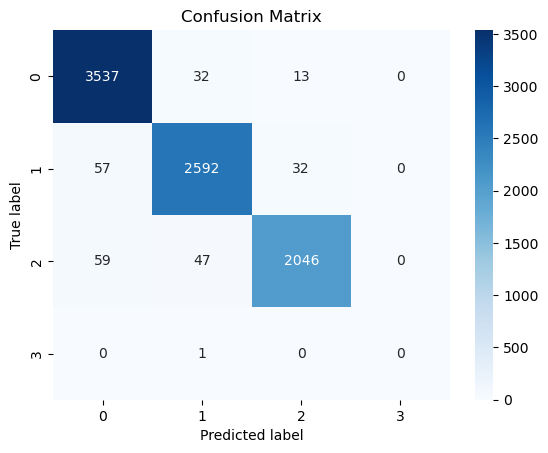

In [71]:
import seaborn as sns
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set the axis labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


#### The confusion matrix shows that:

#### 3,537 instances of class 0 were correctly classified as class 0, 57 were incorrectly classified as class 1, and 59 were incorrectly classified as class 2.
#### 2,592 instances of class 1 were correctly classified as class 1, 32 were incorrectly classified as class 0, and 47 were incorrectly classified as class 2.
#### 2,046 instances of class 2 were correctly classified as class 2, 13 were incorrectly classified as class 0, and 32 were incorrectly classified as class 1.
#### 1 instance of class 3 was incorrectly classified as class 1.